<a href="https://colab.research.google.com/github/vncntprvst/tools/blob/master/demo_fiola_pipeline_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIOLA demo pipeline

Pipeline for online analysis of fluorescence imaging data

Voltage dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).

Calcium dataset courtesy of Sue Ann Koay and David Tank (Princeton University)

@author: @agiovann, @caichangjia, @cxd00


# Installation

In [ ]:
# Install packages
# These lines allow users to install FIOLA with CaImAn
# Note that user needs to run again/restart runtime to use newly installed packages
import os
if os.path.isdir('/content/CaImAn'):
  print('Doing nothing, caiman already installed')
  print('If you need to reinstall delete current runtime')
else: 
  !git clone https://github.com/nel-lab/FIOLA.git
  !git clone https://github.com/flatironinstitute/CaImAn.git
  %cd /content/FIOLA
  !pip install -r requirements_with_caiman.txt
  !pip install h5py==2.10.0
  !pip install -e . 
  %cd /content/CaImAn
  !pip install -e . 
  !python caimanmanager.py install --inplace
  %cd /content/FIOLA
  import sys
  sys.path.append('/content/CaImAn')
  print('Stopping RUNTIME! Please run again to use the newly installed packages.') 
  os.kill(os.getpid(), 9)

Cloning into 'FIOLA'...
remote: Enumerating objects: 1966, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 1966 (delta 117), reused 99 (delta 50), pack-reused 1753
Receiving objects: 100% (1966/1966), 1.79 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (1406/1406), done.
Cloning into 'CaImAn'...
remote: Enumerating objects: 25304, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 25304 (delta 0), reused 0 (delta 0), pack-reused 25303
Receiving objects: 100% (25304/25304), 515.88 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (16983/16983), done.
Updating files: 100% (318/318), done.
/content/FIOLA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.

In [ ]:
from base64 import b64encode
import caiman as cm
from IPython.display import HTML, clear_output
import imageio
import logging
import matplotlib.pyplot as plt
import numpy as np
import pyximport
pyximport.install()
import scipy
from tensorflow.python.client import device_lib
from time import time
    
from fiola.demo_initialize_calcium import run_caiman_init
from fiola.fiolaparams import fiolaparams
from fiola.fiola import FIOLA
from fiola.utilities import download_demo, load, to_2D, movie_iterator

logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]"\
                    "[%(process)d] %(message)s",
                    level=logging.INFO)    
logging.info(device_lib.list_local_devices()) # if GPU is not detected, try to reinstall tensorflow with pip install tensorflow==2.4.1


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Set up parameters

In [ ]:
folder = '/content/FIOLA'
mode = 'calcium'                    # 'voltage' or 'calcium 'fluorescence indicator
# Parameter setting
if mode == 'voltage':
    fnames = download_demo(folder, 'demo_voltage_imaging.hdf5')
    # setting params
    # dataset dependent parameters
    fr = 400                        # sample rate of the movie
    
    num_frames_init =  10000        # number of frames used for initialization
    num_frames_total =  20000       # estimated total number of frames for processing, this is used for generating matrix to store data
    offline_batch = 200             # number of frames for one batch to perform offline motion correction
    batch = 1                       # number of frames processing at the same time using gpu. 1 for online processing. 
    flip = True                     # whether to flip signal to find spikes   
    detrend = True                  # whether to remove the slow trend in the fluorescence data            
    do_deconvolve = True            # If True, perform spike detection for voltage imaging or deconvolution for calcium imaging.
    ms = [10, 10]                   # maximum shift in x and y axis respectively. Will not perform motion correction if None.
    update_bg = True                # update background components for spatial footprints
    filt_window = 15                # window size of median filter for removing the subthreshold activities. It can be integer or a list.
                                    # an integer means the window size of the full median filter. Suggested values range [9, 15]. It needs to be an odd number. 
                                    # a list with two values [x, y] means an antisymmetric median filter which uses x past frames and y future frames.
    minimal_thresh = 3.5            # minimal of the threshold for voltage spike detection. Suggested value range [2.8, 3.5] 
    template_window = 2             # half window size of the template; will not perform template matching if window size equals 0.  
    nb = 1                          # number of background components
    lag = 11                        # lag for retrieving the online result. 5 frames are suggested for calcium imaging. For voltage imaging, it needs to be larger than filt_window // 2 + template_window + 2. 

    options = {
        'fnames': fnames,
        'fr': fr,
        'mode': mode,
        'num_frames_init': num_frames_init, 
        'num_frames_total':num_frames_total,
        'offline_batch': offline_batch,
        'batch':batch,
        'flip': flip,
        'detrend': detrend,
        'do_deconvolve': do_deconvolve,
        'ms': ms,
        'update_bg': update_bg,
        'filt_window': filt_window,
        'minimal_thresh': minimal_thresh,
        'template_window':template_window, 
        'nb': nb, 
        'lag': lag}
    
    
    logging.info('Loading Movie')
    

elif mode == 'calcium':
    #fnames = download_demo(folder, 'demoMovie.tif') 
    fnames = download_demo(folder, 'Sue_2x_3000_40_-46.tif')
    fr = 30                         # sample rate of the movie
    
    mode = 'calcium'                # 'voltage' or 'calcium 'fluorescence indicator
    num_frames_init =   1000         # number of frames used for initialization
    num_frames_total =  2000        # estimated total number of frames for processing, this is used for generating matrix to store data
    offline_batch = 5               # number of frames for one batch to perform offline motion correction
    batch= 1                        # number of frames processing at the same time using gpu. 1 for online processing. 
    flip = False                    # whether to flip signal to find spikes   
    detrend = False                  # whether to remove the slow trend in the fluorescence data            
    dc_param = 0.9995               # DC blocker parameter for removing the slow trend in the fluorescence data. It is usually between
                                    # 0.99 and 1. Higher value will remove less trend. No detrending will perform if detrend=False.
    do_deconvolve = True            # If True, perform spike detection for voltage imaging or deconvolution for calcium imaging.
    ms = [5, 5]                     # maximum shift in x and y axis respectively. Will not perform motion correction if None.
    center_dims = None              # template dimensions for motion correction. If None, the input will the the shape of the FOV
    hals_movie = 'hp_thresh'        # apply hals on the movie high-pass filtered and thresholded with 0 (hp_thresh); movie only high-pass filtered (hp); 
                                    # original movie (orig); no HALS needed if the input is from CaImAn (when init_method is 'caiman' or 'weighted_masks')
    n_split = 1                     # split neuron spatial footprints into n_split portion before performing matrix multiplication, increase the number when spatial masks are larger than 2GB
    nb = 2                          # number of background components
    trace_with_neg=True             # return trace with negative components (noise) if True; otherwise the trace is cutoff at 0
    lag = 5                         # lag for retrieving the online result.
                    
    options = {
        'fnames': fnames,
        'fr': fr,
        'mode': mode, 
        'num_frames_init': num_frames_init, 
        'num_frames_total':num_frames_total,
        'offline_batch': offline_batch,
        'batch':batch,
        'flip': flip,
        'detrend': detrend,
        'dc_param': dc_param,            
        'do_deconvolve': do_deconvolve,
        'ms': ms,
        'hals_movie': hals_movie,
        'center_dims':center_dims, 
        'n_split': n_split,
        'nb' : nb, 
        'trace_with_neg':trace_with_neg, 
        'lag': lag}
else: 
    raise Exception('mode must be either calcium or voltage')

# Load movie.
### If dealing with calcium data, run initialization with CaImAn

In [ ]:
if mode == 'voltage':
    logging.info('Loading Movie')
    mov = cm.load(fnames, subindices=range(num_frames_init))
    fnames_init = fnames.split('.')[0] + '_init.tif'
    mov.save(fnames_init)
    path_ROIs = download_demo(folder, 'demo_voltage_imaging_ROIs.hdf5')
    mask = load(path_ROIs)
    template = np.median(mov, 0)
    
elif mode == 'calcium':
    mov = cm.load(fnames, subindices=range(num_frames_init))
    fnames_init = fnames.split('.')[0] + '_init.tif'
    mov.save(fnames_init)
    
    # run caiman initialization. User might need to change the parameters 
    # inside the file to get good initialization result
    caiman_file = run_caiman_init(fnames_init, pw_rigid=True, 
                                      max_shifts=ms, gnb=nb, rf=15, K=4, gSig=[4, 4])
    
    # load results of initialization
    cnm2 = cm.source_extraction.cnmf.cnmf.load_CNMF(caiman_file)
    estimates = cnm2.estimates
    template = cnm2.estimates.template
    Cn = cnm2.estimates.Cn


Decode mmap filename /content/FIOLA/Sue_2x_3000_40_-46_init_els__d1_170_d2_170_d3_1_order_F_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/Sue_2x_3000_40_-46_init_els__d1_170_d2_170_d3_1_order_F_frames_1000.mmap
Decode mmap filename /content/FIOLA/Sue_2x_3000_40_-46_init_els__d1_170_d2_170_d3_1_order_F_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_or

Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap


Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap


Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
89
*** Variable cnn_preds has not the same number of components as A ***
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap


Streaming output truncated to the last 5000 lines.
Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in

Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_

Streaming output truncated to the last 5000 lines.
Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in

Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap
Decode mmap filename /content/FIOLA/memmap_

Decode mmap filename /content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000.mmap


63
*** Variable cnn_preds has not the same number of components as A ***
{'start': 1675095388.525468, 'end': 1675095669.0771546}
/content/FIOLA/memmap_d1_170_d2_170_d3_1_order_C_frames_1000_caiman_init.hdf5


### Display calculated template and overlaid neuron masks from initialization.

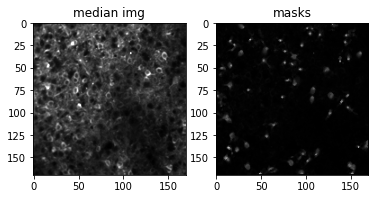

In [ ]:
display_images = True
if display_images:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(template, vmax=np.percentile(template, 99.9), cmap='gray')
    ax[0].set_title('median img')
    ax[1].set_title('masks')
    if mode == 'voltage':
        ax[1].imshow(mask.mean(0), cmap='gray')
    elif mode == 'calcium':
        Ab = np.hstack((estimates.A.toarray(), estimates.b))
        Ab = Ab.reshape([mov.shape[1], mov.shape[2], -1], order='F').transpose([2, 0, 1])
        ax[1].imshow(Ab.mean(0), cmap='gray')

# GPU motion correction

In [ ]:
#%% Run FIOLA: set variable to true to include that portion of the pipeline.
# example motion correction
motion_correct = True
# example source separation
do_nnls = True

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


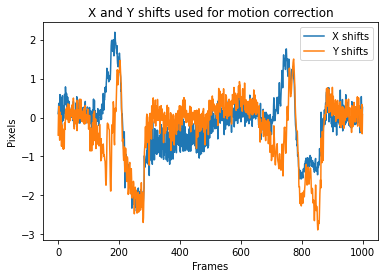

In [ ]:
#%% Mot corr only
if motion_correct:
    params = fiolaparams(params_dict=options)
    fio = FIOLA(params=params)
    # run motion correction on GPU on the initialization movie
    mc_nn_mov, shifts_fiola, _ = fio.fit_gpu_motion_correction(mov, template, fio.params.mc_nnls['offline_batch'], min_mov=mov.min())             
    plt.plot(shifts_fiola)
    plt.xlabel('Frames')
    plt.ylabel('Pixels')                 
    plt.legend(['X shifts', 'Y shifts'])
    plt.title('X and Y shifts used for motion correction')
else:    
    mc_nn_mov = mov

In [ ]:
#%% compare with original movie
display_movie = True
if display_movie:
    ds_ratio = 0.2
    moviehandle = cm.concatenate([mov.resize(1, 1, ds_ratio),
                   cm.movie(mc_nn_mov).resize(1, 1, ds_ratio)], axis=2)
    min_, max_ = np.min(moviehandle), np.max(moviehandle)
    moviehandle = np.array((moviehandle-min_)/(max_-min_)*255,dtype='uint8')
    imageio.mimwrite('/root/caiman_data/motion_correct.mp4', moviehandle, fps = 20, quality=8)

mp4 = open('/root/caiman_data/motion_correct.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# GPU source extraction

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


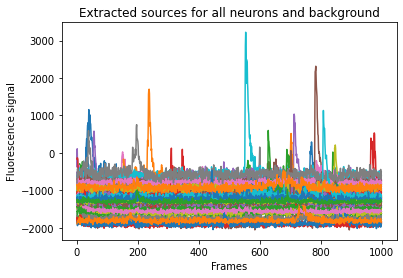

In [ ]:
#%% NNLS only
if do_nnls:
    params = fiolaparams(params_dict=options)
    fio = FIOLA(params=params)
    if mode == 'voltage':
        A = scipy.sparse.coo_matrix(to_2D(mask, order='F')).T
        fio.fit_hals(mc_nn_mov, A)
        Ab = fio.Ab # Ab includes spatial masks of all neurons and background
    else:
        Ab = np.hstack((estimates.A.toarray(), estimates.b))
    trace_fiola, _ = fio.fit_gpu_nnls(mc_nn_mov, Ab, batch_size=fio.params.mc_nnls['offline_batch']) 
    plt.plot(trace_fiola[:-nb].T)
    plt.xlabel('Frames')
    plt.ylabel('Fluorescence signal') 
    plt.title('Extracted sources for all neurons and background')             

else: # use traces of CaImAn       
    if trace_with_neg == True:
        trace_fiola = np.vstack((estimates.C+estimates.YrA, estimates.f))
    else:
        trace_fiola = estimates.C+estimates.YrA
        trace_fiola[trace_fiola < 0] = 0
        trace_fiola = np.vstack((trace_fiola, estimates.f))

# Set up whole pipeline with initialization

In [ ]:
#%% set up online pipeline
params = fiolaparams(params_dict=options)
fio = FIOLA(params=params)
if mode == 'voltage': # not thoroughly tested and computationally intensive for large files, it will estimate the baseline
    fio.fit_hals(mc_nn_mov, A)
    Ab = fio.Ab
else:
    Ab = np.hstack((estimates.A.toarray(), estimates.b))
Ab = Ab.astype(np.float32)        
fio = fio.create_pipeline(mc_nn_mov, trace_fiola, template, Ab, min_mov=mov.min())

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# Online analysis

mapping tif file
processed 1000 frames


Text(0.5, 1.0, 'Time per frame')

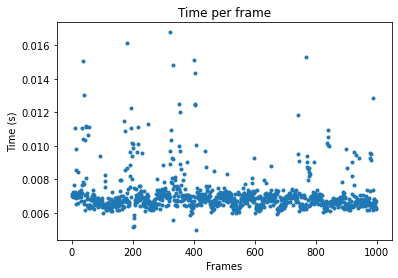

In [ ]:
time_per_step = np.zeros((num_frames_total-num_frames_init) // batch)
online_trace = np.zeros((fio.Ab.shape[-1], num_frames_total-num_frames_init), dtype=np.float32)
online_trace_deconvolved = np.zeros((fio.Ab.shape[-1] - fio.params.hals['nb'], num_frames_total-num_frames_init), dtype=np.float32)
start = time()
    
for idx, memmap_image in movie_iterator(fnames, num_frames_init, num_frames_total, batch_size=batch):
    if idx % 1000 == 0:
            print(f'processed {idx} frames')        
    fio.fit_online_frame(memmap_image) 
    online_trace[:, idx-num_frames_init:idx-num_frames_init+batch] = fio.pipeline.saoz.trace[:,idx-batch:idx]
    online_trace_deconvolved[:, idx-num_frames_init:idx-num_frames_init+batch] = fio.pipeline.saoz.trace_deconvolved[:,idx-batch-fio.params.retrieve['lag']:idx-fio.params.retrieve['lag']]
    time_per_step[(idx-num_frames_init)//batch] = (time()-start)

fio.pipeline.saoz.online_trace = online_trace
fio.pipeline.saoz.online_trace_deconvolved = online_trace_deconvolved

logging.info(f'total time online: {time()-start}')
logging.info(f'time per frame online: {(time()-start)/(num_frames_total-num_frames_init)}')
plt.plot(np.diff(time_per_step),'.')
plt.xlabel('Frames')
plt.ylabel('Time (s)')
plt.title('Time per frame')

# Visualization

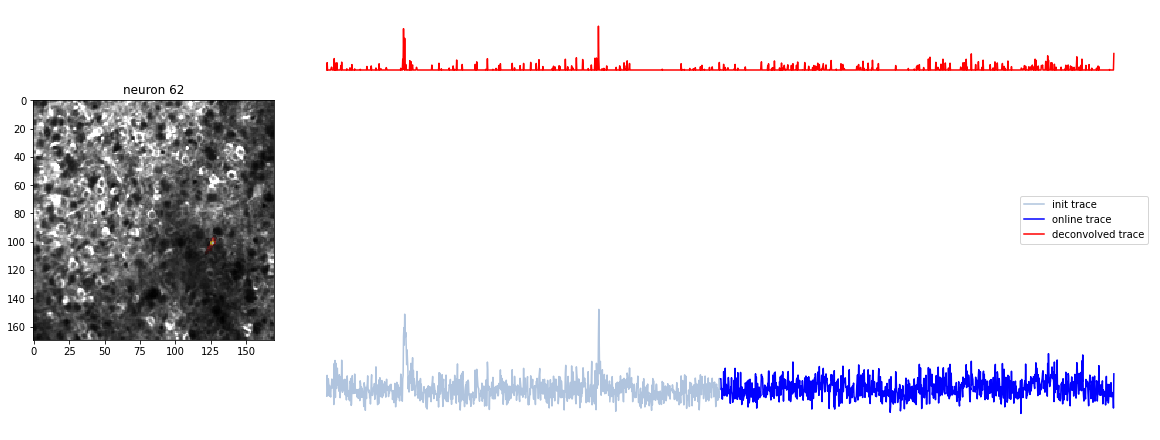

In [ ]:
#%% visualize result
fio.compute_estimates()
indexes = list(range(Ab.shape[1]))[:-nb]
spatials = Ab.reshape([mov.shape[1], mov.shape[2], -1], order='F').transpose([2, 0, 1])
for i in range(len(indexes)):  
  fig = plt.figure(constrained_layout=True,figsize=(16,6))
  gs = fig.add_gridspec(1, 3)
  ax1 = fig.add_subplot(gs[:1])
  ax2 = fig.add_subplot(gs[1:])            

  spatial = spatials[indexes][i].copy()
  ax1.imshow(template, interpolation='None', cmap=plt.cm.gray, vmax=np.percentile(template, 98))
  spatial[spatial == 0] = np.nan
  ax1.imshow(spatial, interpolation='None',
            alpha=0.5, cmap=plt.cm.hot)
  ax1.set_title(f'neuron {indexes[i]}')
  plt.axis('off')     

  if mode == 'voltage':
    tr = fio.estimates.t[indexes][i]
    spikes = np.delete(fio.estimates.index[indexes][i], fio.estimates.index[indexes][i]==0)
    ax2.plot(np.arange(0, num_frames_init), tr[:num_frames_init], color='lightsteelblue')
    ax2.plot(np.arange(num_frames_init, num_frames_total), tr[num_frames_init:num_frames_total], color='blue')
    h_min = tr.max()
    ax2.plot(spikes, np.max(tr) * np.ones(spikes.shape),
            color='r', marker='.', markersize=5, fillstyle='none', linestyle='none')
    ax2.legend(['init trace', 'online trace', 'spikes'])
  elif mode == 'calcium':
    tr = fio.estimates.trace[indexes][i]
    tr_dec = fio.estimates.trace_deconvolved[indexes][i]
    ax2.plot(np.arange(0, num_frames_init), tr[:num_frames_init], color='lightsteelblue')
    ax2.plot(np.arange(num_frames_init, num_frames_total), tr[num_frames_init:num_frames_total], color='blue')
    ax2.plot(tr_dec, color='red')
    ax2.legend(['init trace', 'online trace', 'deconvolved trace'])
    

  display(fig)
  clear_output(wait=True)    
  plt.pause(0.5) 
    
    

In [ ]:
#%% save result
if True:
        np.save(folder + f'/fiola_result', fio.estimates)